<a href="https://colab.research.google.com/github/amr-elbana/EcoSortAI-Classifier/blob/main/notebooks/Augmented_waste_efficientnetB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import keras,os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB2

In [5]:
# Define paths and constants
data_dir = "/content/drive/MyDrive/DL_Project/realWaste_Augmented"
test_dir = "/content/drive/MyDrive/DL_Project/realWaste_Augmented_test"
batch_size = 32
target_size = (224, 224)
epochs = 30

In [6]:
# Create an ImageDataGenerator with EfficientNetB2 preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNetB2-specific preprocessing
    validation_split=0.2,  # Use 20% of data for validation
    rotation_range=20,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,        # Randomly apply shearing transformations
    zoom_range=0.2,         # Randomly zoom in or out on images
    horizontal_flip=True,   # Randomly flip images horizontally
)

# Flow training data from the directory and apply preprocessing and augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to EfficientNetB2 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification
    subset='training',            # Use 80% of data for training
    seed=42,                      # Set seed for reproducibility
    shuffle=True                  # Shuffle the data to improve training
)

# Flow validation data from the directory and apply preprocessing (no augmentation for validation)
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to EfficientNetB2 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification
    subset='validation',          # Use 20% of data for validation
    shuffle=False                 # No need to shuffle validation data
)

# ... (rest of the code remains the same)

# Check the number of samples in each generator
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Validation batches per epoch: {len(validation_generator)}")

Found 4020 images belonging to 2 classes.
Found 1003 images belonging to 2 classes.
Training samples: 4020
Validation samples: 1003
Training batches per epoch: 126
Validation batches per epoch: 32


In [7]:
# Create an ImageDataGenerator for EfficientNetB2 preprocessing (no augmentation for the test set)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # EfficientNetB2-specific preprocessing
)

# Flow data from the test directory and apply preprocessing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,  # efficientnetB2 input size
    batch_size=batch_size,
    class_mode='binary',     # Binary classification for the test set
    shuffle=False            # Do not shuffle test data to keep results consistent
)

# Check the number of samples in the test set
print(f"Test samples: {test_generator.samples}")
print(f"Test batches: {len(test_generator)}")

Found 1255 images belonging to 2 classes.
Test samples: 1255
Test batches: 40


In [8]:
"""EfficientNetB2 is a functional model, and its layers are interdependent.
Adding the entire model instead of individual layers ensures the integrity of its structure,
 preventing errors during training.
 Using GlobalAveragePooling2D further optimizes the architecture for the task."""

import os
from tensorflow.keras.layers import GlobalAveragePooling2D
def create_model():
    # Load EfficientNetB2 model with pretrained weights, excluding the top (fully connected) layers
    efficientnet_base = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of EfficientNetB2 to retain the pre-trained weights
    efficientnet_base.trainable = False

    # Build the model
    model = Sequential([
        efficientnet_base,  # Add the entire base model
        GlobalAveragePooling2D(),  # Use global pooling instead of Flatten, This is more efficient and typically used for pre-trained convolutional models.
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # For binary classification
    ])

    # Compile the model
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Define the model
model = create_model()


31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
# Define callbacks
checkpoint_path = "/content/drive/MyDrive/DL_Project/Augmented_Models/Waste_Augmented_EfficientNetB2_{epoch:02d}-{val_accuracy:0.2f}.keras"

# ModelCheckpoint: Save best model based on val_accuracy
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping_monitor = EarlyStopping(patience = 10)

# Train the model
History = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[checkpoint, early_stopping_monitor]
)
model.save('/content/drive/MyDrive/DL_Project/Augmented_Models/Augmented_EfficientNetB2_best_model.h5')

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8242 - loss: 0.3742 
Epoch 1: val_accuracy improved from -inf to 0.77966, saving model to /content/drive/MyDrive/DL_Project/Augmented_Models/Waste_Augmented_EfficientNetB2_01-0.78.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 2134s 16s/step - accuracy: 0.8247 - loss: 0.3734 - val_accuracy: 0.7797 - val_loss: 0.5140
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9288 - loss: 0.1790
Epoch 2: val_accuracy improved from 0.77966 to 0.82552, saving model to /content/drive/MyDrive/DL_Project/Augmented_Models/Waste_Augmented_EfficientNetB2_02-0.83.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 91s 697ms/step - accuracy: 0.9288 - loss: 0.1790 - val_accuracy: 0.8255 - val_loss: 0.3802
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9402 - loss: 0.1513
Epoch 3: val_accuracy did not improve from 0.82552
126/126 ━━━━━━━━━━━━━━━━━━━━ 92s 695ms/step - accuracy: 0.9402 - loss: 0.1513 - val_accuracy: 0.8225 - val_loss: 0.4229
Epoc

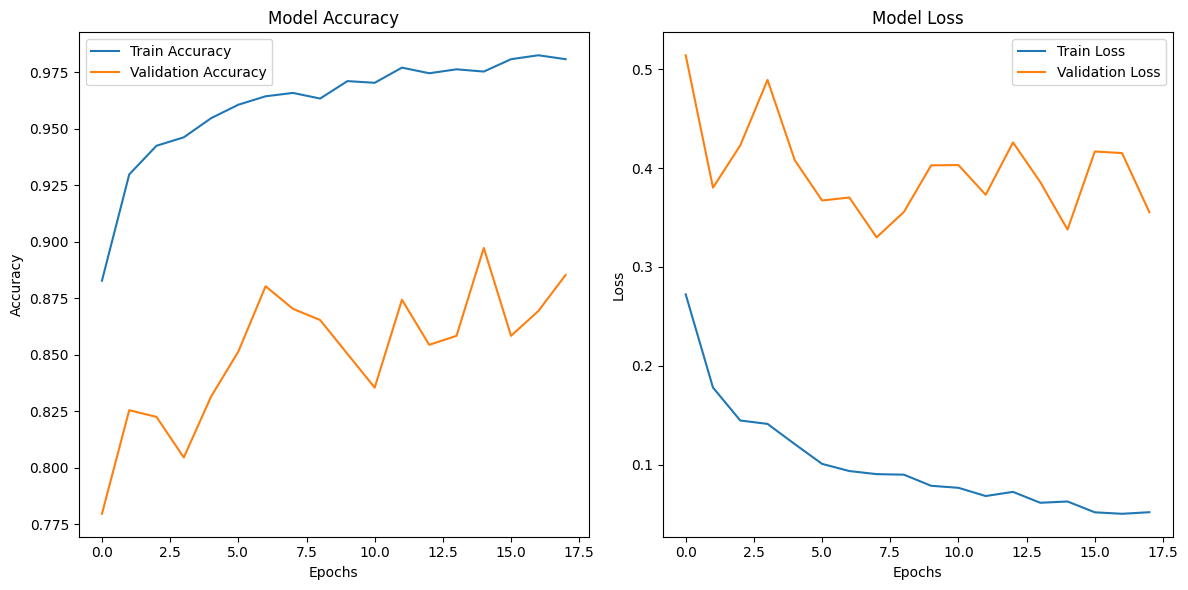

In [10]:
import matplotlib.pyplot as plt

# Extract the training history
history = History.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
final_train_acc = History.history['accuracy'][-1]
final_val_acc = History.history['val_accuracy'][-1]
final_train_loss = History.history['loss'][-1]
final_val_loss = History.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Final Training Accuracy: 0.9808
Final Validation Accuracy: 0.8853
Final Training Loss: 0.0522
Final Validation Loss: 0.3554


In [12]:
if 'lr' in History.history:
    plt.plot(History.history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

In [13]:
import json

# Save history to a JSON file on Google Drive
with open("/content/drive/MyDrive/DL_Project/Augmented_Models/training_history.json", "w") as f:
    json.dump(History.history, f)

# Load the history later
with open("/content/drive/MyDrive/DL_Project/Augmented_Models/training_history.json", "r") as f:
    loaded_history = json.load(f)
    print(loaded_history)

{'accuracy': [0.8828358054161072, 0.9298507571220398, 0.9425373077392578, 0.9462686777114868, 0.9547263383865356, 0.9606965184211731, 0.9644278883934021, 0.9659203886985779, 0.9634328484535217, 0.9711442589759827, 0.9703980088233948, 0.9771144390106201, 0.9746268391609192, 0.9763681888580322, 0.9753731489181519, 0.9808457493782043, 0.9825870394706726, 0.9808457493782043], 'loss': [0.2723389267921448, 0.17815834283828735, 0.14486555755138397, 0.14142638444900513, 0.12096695601940155, 0.10102999955415726, 0.0937771424651146, 0.0906648263335228, 0.09010950475931168, 0.07888087630271912, 0.07683326303958893, 0.06853732466697693, 0.07273469865322113, 0.06172473728656769, 0.06301534920930862, 0.05207148566842079, 0.050578147172927856, 0.052177514880895615], 'val_accuracy': [0.7796609997749329, 0.8255234360694885, 0.8225324153900146, 0.8045862317085266, 0.8315054774284363, 0.8514456748962402, 0.8803589344024658, 0.8703888058662415, 0.8654037714004517, 0.8504486680030823, 0.8354935050010681, 0

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
import tensorflow as tf
checkpoint_path = '/content/drive/MyDrive/DL_Project/Augmented_Models/Augmented_EfficientNetB2_best_model.h5'
model = tf.keras.models.load_model(checkpoint_path)

test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels
predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()

# Get the true labels
true_labels = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Recyclable', 'Non-Recyclable'])
print("\nClassification Report:\n", class_report)

# Accuracy Score
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nAccuracy:", accuracy)

# F1 Score
f1 = f1_score(true_labels, predicted_labels)
print("\nF1 Score:", f1)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 935s 24s/step
Confusion Matrix:
 [[600  37]
 [ 32 586]]

Classification Report:
                 precision    recall  f1-score   support

    Recyclable       0.95      0.94      0.95       637
Non-Recyclable       0.94      0.95      0.94       618

      accuracy                           0.95      1255
     macro avg       0.94      0.95      0.95      1255
  weighted avg       0.95      0.95      0.95      1255


Accuracy: 0.9450199203187251

F1 Score: 0.9443996776792909


In [15]:
# Define where to save everything
results_save_path = "/content/drive/MyDrive/DL_Project/Augmented_Models/Augmented_EfficientNetB2_results.txt"
conf_matrix_save_path = "/content/drive/MyDrive/DL_Project/Augmented_Models/Augmented_EfficientNetB2_confusion_matrix.png"
with open(results_save_path, "w") as file:
    file.write(f"Accuracy: {accuracy:.4f}\n")
    file.write(f"F1 Score: {f1:.4f}\n")
    file.write(f"classification Report:\n {class_report}\n")
    file.write(f"Confusion Matrix:\n{conf_matrix}\n")

print(f"Results saved to {results_save_path}")

Results saved to /content/drive/MyDrive/DL_Project/Augmented_Models/Augmented_EfficientNetB2_results.txt


In [16]:
import matplotlib.pyplot as plt  # Import the plotting library and assign it to the alias 'plt'
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Recyclable", "Non-Recyclable"], yticklabels=["Recyclable", "Non-Recyclable"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Save confusion matrix as an image
plt.savefig(conf_matrix_save_path)
print(f"Confusion matrix saved to {conf_matrix_save_path}")
from IPython.display import Image
Image(filename=conf_matrix_save_path)
plt.close()  # Close the plot to free up memory

Confusion matrix saved to /content/drive/MyDrive/DL_Project/Augmented_Models/Augmented_EfficientNetB2_confusion_matrix.png


In [ ]:
from google.colab import runtime
runtime.unassign()
